# Dataset

In [1]:
from pathlib import Path

def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))

In [2]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import wandb
from tqdm import tqdm as progress_bar

# from cloud_diffusion.utils import ls

PROJECT_NAME = "ddpm_clouds"
DATASET_ARTIFACT = 'capecape/gtc/np_dataset:v0'

class DummyNextFrameDataset:
    "Dataset that returns random images"
    def __init__(self, num_frames=4, img_size=64, N=1000):
        self.img_size = img_size
        self.num_frames = num_frames
        self.N = N

    def __getitem__(self, idx):
        return torch.randn(self.num_frames, self.img_size, self.img_size)
    
    def __len__(self):
        return self.N


class CloudDataset:
    """Dataset for cloud images
    It loads numpy files from wandb artifact and stacks them into a single array
    It also applies some transformations to the images
    """
    def __init__(self, 
                 files, # list of numpy files to load (they come from the artifact)
                 num_frames=4, # how many consecutive frames to stack
                 scale=True, # if we images to interval [-0.5, 0.5]
                 img_size=64, # resize dim, original images are big (446, 780)
                 valid=False, # if True, transforms are deterministic
                ):
        
        tfms = [T.Resize((img_size, int(img_size*1.7)))] if img_size is not None else []
        tfms += [T.RandomCrop(img_size)] if not valid else [T.CenterCrop(img_size)]
        self.tfms = T.Compose(tfms)
        self.load_data(files, num_frames, scale)
        
    def load_day(self, file, scale=True):
        one_day = np.load(file)
        if scale:
            one_day = 0.5 - self._scale(one_day)
        return one_day

    def load_data(self, files, num_frames, scale):
        "Loads all data into a single array self.data"
        data = []
        for file in progress_bar(files, leave=False):
            one_day = self.load_day(file, scale)
            wds = np.lib.stride_tricks.sliding_window_view(
                one_day.squeeze(), 
                num_frames, 
                axis=0).transpose((0,3,1,2))
            data.append(wds)
            # pbar.comment = f"Creating CloudDataset from {file}"
        self.data = np.concatenate(data, axis=0)

    def shuffle(self):
        """Shuffles the dataset, useful for getting 
        interesting samples on the validation dataset"""
        idxs = torch.randperm(len(self.data))
        self.data = self.data[idxs]
        return self

    @staticmethod
    def _scale(arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)
    
    def __getitem__(self, idx):
        return self.tfms(torch.from_numpy(self.data[idx]))
    
    def __len__(self): return len(self.data)

    def save(self, fname="cloud_frames.npy"):
        np.save(fname, self.data)


class CloudDatasetInference(CloudDataset):
     def load_data(self, files, num_frames=None, scale=None):
        "Loads all data into a single array self.data"
        data = []
        max_length = 100
        for file in files:
            one_day = self.load_day(file, scale)
            data.append(one_day)
            max_length = min(max_length, len(one_day))
        self.data = np.stack([d[:max_length] for d in data], axis=0).squeeze()


def download_dataset(at_name, project_name):
    "Downloads dataset from wandb artifact"
    def _get_dataset(run):
        artifact = run.use_artifact(at_name, type='dataset')
        return artifact.download()

    if wandb.run is not None:
        run = wandb.run
        artifact_dir = _get_dataset(run)
    else:
        run = wandb.init(project=project_name, job_type="download_dataset")
        artifact_dir = _get_dataset(run)
        run.finish()

    files = ls(Path(artifact_dir))
    return files


c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Impossibile trovare la procedura specificata'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
files = download_dataset(DATASET_ARTIFACT, project_name=PROJECT_NAME)
train_ds = CloudDataset(files)
print(f"Let's grab 5 samples: {train_ds[0:5].shape}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\riccardo/.netrc


wandb: Downloading large artifact np_dataset:v0, 3816.62MB. 30 files... Done. 0:7:5.2


Let's grab 5 samples: torch.Size([5, 4, 64, 64])


c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
train_ds[0].shape

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 64, 64])

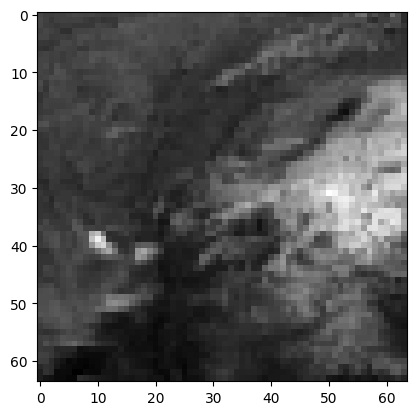

In [8]:
# Show the first sample image of the training dataset
import matplotlib.pyplot as plt

plt.imshow(train_ds[0][0], cmap='gray')

# Model

In [9]:
torch.__version__

'1.13.1+cu117'

In [ ]:
from pathlib import Path

import wandb
import fastcore.all as fc

import torch
from torch import nn
from diffusers import UNet2DModel

try:
    from denoising_diffusion_pytorch.simple_diffusion import UViT
except:
    raise ImportError("Please install denoising_diffusion_pytorch with `pip install denoising_diffusion_pytorch`")


def init_unet(model):
    "From Jeremy's bag of tricks on fastai V2 2023"
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): nn.init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

class WandbModel:
    "A model that can be saved to wandb"
    @classmethod
    def from_checkpoint(cls, model_params, checkpoint_file):
        "Load a UNet2D model from a checkpoint file"
        model = cls(**model_params)
        print(f"Loading model from: {checkpoint_file}")
        model.load_state_dict(torch.load(checkpoint_file))
        return model

    @classmethod
    def from_artifact(cls, model_params, artifact_name):
        "Load a UNet2D model from a wandb.Artifact, need to be run in a wandb run"
        artifact = wandb.use_artifact(artifact_name, type='model')
        artifact_dir = Path(artifact.download())
        chpt_file = list(artifact_dir.glob("*.pth"))[0]
        return cls.from_checkpoint(model_params, chpt_file)

def get_unet_params(model_name="unet_small", num_frames=4):
    "Return the parameters for the diffusers UNet2d model"
    if model_name == "unet_small":
        return dict(
            block_out_channels=(16, 32, 64, 128), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    elif model_name == "unet_big":
        return dict(
            block_out_channels=(32, 64, 128, 256), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'unet_small' or 'unet_big'")

class UNet2D(UNet2DModel, WandbModel):
    def __init__(self, *x, **kwargs):
        super().__init__(*x, **kwargs)
        init_unet(self)

    def forward(self, *x, **kwargs):
        return super().forward(*x, **kwargs).sample ## Diffusers's UNet2DOutput class


## Simple Diffusion paper

def get_uvit_params(model_name="uvit_small", num_frames=4):
    "Return the parameters for the diffusers UViT model"
    if model_name == "uvit_small":
        return dict(
            dim=512,
            ff_mult=2,
            vit_depth=4,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    elif model_name == "uvit_big":
        return dict(
            dim=1024,
            ff_mult=4,
            vit_depth=8,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'uvit_small' or 'uvit_big'")

class UViTModel(UViT, WandbModel): pass